In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import pystan
from sklearn import datasets, decomposition 
from py_stan_code.helper_functions import StanModel_cache

%matplotlib inline 

In [3]:
def stan_model(file):
    with open(file) as f:
        stan_code = f.read()
    return StanModel_cache(model_code=stan_code)
    
    
file1 = "py_stan_code/ppca_house.stan"
file2 = "py_stan_code/ppca.stan"

ppca_house_model = stan_model(file1)
ppca_model = stan_model(file2)

Using cached StanModel
Using cached StanModel


In [4]:
def run_calc(model, Y, N, D, Q, chains=4, iterations=2000):
    data_dict = {'N':N, 'D':D, 'Q':Q, 'Y':Y}
    samples = model.sampling(data_dict, chains=chains, iter=iterations)
    return samples


def sign_convention(U):
    """
    sign convention
    """
    return np.array( [-U[:,q] if U[0,q] < 0 else U[:,q] for q in range(U.shape[1])] ).T

<h1>Iris Dataset</h1>

In [5]:
Q_fit = 2

Y =  datasets.load_iris()["data"]
Y = (Y - Y.mean(axis=0))/Y.std(axis=0)
N,D = Y.shape

In [6]:
%time ppca = run_calc(ppca_model, Y, N, D, Q_fit)
%time ppca_house = run_calc(ppca_house_model, Y, N, D, Q_fit)

CPU times: user 172 ms, sys: 304 ms, total: 476 ms
Wall time: 1min 47s
CPU times: user 160 ms, sys: 340 ms, total: 500 ms
Wall time: 1min 57s


In [7]:
# PCA solution
pca = decomposition.PCA(n_components=Q_fit)
pca.fit(Y)
U_pca = pca.components_.T   
U_pca = sign_convention(U_pca)
sigma_pca = np.sqrt(pca.explained_variance_)
W_pca = np.dot(U_pca,np.diag(sigma_pca))

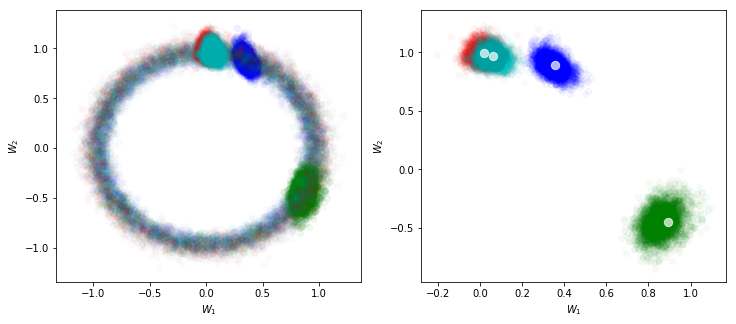

In [8]:
W_ppca = ppca.extract(['W'])['W']
W_house = ppca_house.extract(['W_n'])['W_n']


c = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
def plt_info(ax, x=None, y=None, legend=None, title=None):
    if x is not None: ax.set_xlabel(x)
    if y is not None: ax.set_ylabel(y)
    if legend is not None: ax.legend()
    if title is not None: ax.set_title(title)
        

fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,2,1)
for d in range(D):
    ax.scatter(W_ppca[:,d,0], W_ppca[:,d,1], alpha=0.02, c=c[d], rasterized=True)
    ax.scatter(W_house[:,d,0], W_house[:,d,1], alpha=0.05, c=c[d], rasterized=True)
plt_info(ax, '$W_1$', '$W_2$')

ax = fig.add_subplot(1,2,2)
for d in range(D):
    ax.scatter(W_house[:,d,0], W_house[:,d,1], alpha=0.03, c=c[d], rasterized=True)
plt_info(ax, '$W_1$', '$W_2$')

ax.scatter(W_pca[:,1], W_pca[:,0], marker='o', s=70,  c='w', alpha=0.7)

plt.show()